In [35]:
from mpe2 import simple_spread_v3
from Failure_API.src.failure_api.communication_models.markov_model import BaseMarkovModel
from Failure_API.src.failure_api.wrappers import CommunicationWrapper
from pettingzoo.utils import aec_to_parallel
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
import numpy as np
from tqdm import trange

# --- Configs ---
N = 3
max_cycles = 25
episodes = 2
update_every = 5

# --- Setup ---
env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
agent_ids = env.possible_agents

# Use default transition matrix (already 0.9 stay same, 0.1 flip)
markov_model = BaseMarkovModel(agent_ids=agent_ids)

# Wrap environment
wrapped_env = CommunicationWrapper(env, failure_models=[markov_model])
parallel_env = aec_to_parallel(wrapped_env)


In [36]:
for ep in range(episodes):
    print(f"\n🎬 Episode {ep+1}")
    obs, _ = parallel_env.reset(seed=ep)
    
    for step in range(max_cycles):
        if step % update_every == 0:
            # Manually trigger connectivity update
            markov_model.update_connectivity(wrapped_env.comms_matrix)
            print(f"\n🔁 Step {step} | Updated Comm Matrix:")
            print(wrapped_env.comms_matrix.as_numpy())

        # Take random actions
        actions = {agent: parallel_env.action_space(agent).sample() for agent in agent_ids}
        obs, rewards, terminations, truncations, infos = parallel_env.step(actions)



🎬 Episode 1

🔁 Step 0 | Updated Comm Matrix:
[[0 1 1]
 [0 0 1]
 [1 0 0]]

🔁 Step 5 | Updated Comm Matrix:
[[0 1 1]
 [0 0 1]
 [1 1 0]]

🔁 Step 10 | Updated Comm Matrix:
[[0 1 0]
 [1 0 1]
 [0 0 0]]

🔁 Step 15 | Updated Comm Matrix:
[[0 1 0]
 [1 0 0]
 [1 1 0]]

🔁 Step 20 | Updated Comm Matrix:
[[0 1 1]
 [0 0 1]
 [1 0 0]]

🎬 Episode 2

🔁 Step 0 | Updated Comm Matrix:
[[0 0 1]
 [1 0 0]
 [1 1 0]]

🔁 Step 5 | Updated Comm Matrix:
[[0 0 0]
 [1 0 0]
 [1 1 0]]

🔁 Step 10 | Updated Comm Matrix:
[[0 1 1]
 [0 0 1]
 [0 1 0]]

🔁 Step 15 | Updated Comm Matrix:
[[0 1 0]
 [0 0 0]
 [0 1 0]]

🔁 Step 20 | Updated Comm Matrix:
[[0 0 0]
 [0 0 1]
 [1 1 0]]


In [37]:

matrix_log = []

for ep in range(episodes):
    obs, _ = parallel_env.reset(seed=ep)

    for step in range(max_cycles):
        if step % update_every == 0:
            markov_model.update_connectivity(wrapped_env.comms_matrix)
            matrix = wrapped_env.comms_matrix.as_numpy().copy()
            matrix_log.append((step, matrix))


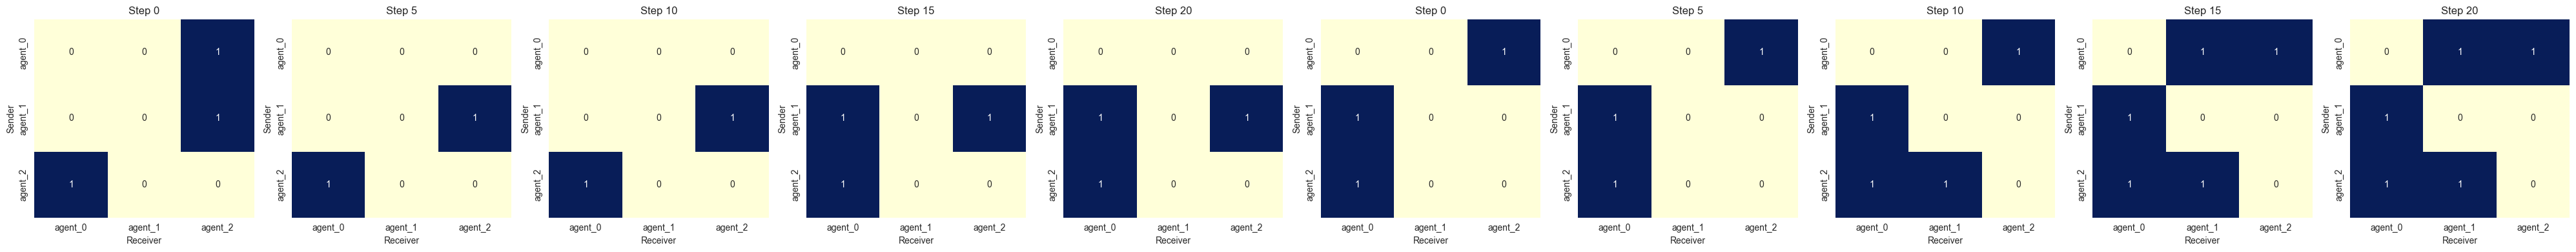

In [38]:
def plot_matrices(matrix_log, agent_ids):
    num_plots = len(matrix_log)
    fig, axs = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))

    for i, (step, matrix) in enumerate(matrix_log):
        ax = axs[i] if num_plots > 1 else axs
        sns.heatmap(matrix.astype(int), annot=True, cmap="YlGnBu", cbar=False, 
                    xticklabels=agent_ids, yticklabels=agent_ids, ax=ax)
        ax.set_title(f"Step {step}")
        ax.set_xlabel("Receiver")
        ax.set_ylabel("Sender")

    plt.tight_layout()
    plt.show()

# Run this after simulation
plot_matrices(matrix_log, agent_ids)


In [39]:
def animate_comm_matrix(matrix_log, agent_ids, interval=1000):
    fig, ax = plt.subplots(figsize=(5, 5))

    def update(frame):
        ax.clear()
        step, matrix = matrix_log[frame]
        sns.heatmap(matrix.astype(int), annot=True, cmap="YlGnBu", cbar=False,
                    xticklabels=agent_ids, yticklabels=agent_ids, ax=ax)
        ax.set_title(f"Communication Matrix — Step {step}")
        ax.set_xlabel("Receiver")
        ax.set_ylabel("Sender")

    ani = animation.FuncAnimation(fig, update, frames=len(matrix_log), interval=interval)
    plt.close(fig)
    return ani


In [40]:
from IPython.display import HTML

# Create and display animation
ani = animate_comm_matrix(matrix_log, agent_ids)
HTML(ani.to_jshtml())


## SIGNAL MODEL

In [84]:
from mpe2 import simple_spread_v3
from Failure_API.src.failure_api.communication_models import SignalBasedModel
from Failure_API.src.failure_api.wrappers import CommunicationWrapper
from pettingzoo.utils import aec_to_parallel
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from tqdm import trange
from utils.position_utils import make_position_fn


In [85]:
# Parameters
N = 3
max_cycles = 25
update_every = 5
episodes = 1


# Create base env
base_env = simple_spread_v3.env(N=N, max_cycles=max_cycles)
agent_ids = base_env.possible_agents

# Get position function for SignalBasedModel
pos_fn = make_position_fn(base_env, return_batch=True)

# Create the signal model
signal_model = SignalBasedModel(
    agent_ids=agent_ids,
    tx_power=1.0,             # You can lower this to simulate weak transmitters
    min_strength=2.0,         # Below this, communication fails
    dropout_alpha=0.0,        # Set >0 to make distance probabilistic
    pos_fn=pos_fn
)

# Wrap environment
wrapped_env = CommunicationWrapper(base_env, failure_models=[signal_model])
parallel_env = aec_to_parallel(wrapped_env)


In [86]:
for ep in range(episodes):
    print(f"\n🎬 Episode {ep+1}")
    obs, _ = parallel_env.reset(seed=ep)

    # Force one initial step to trigger internal setup
    actions = {agent: parallel_env.action_space(agent).sample() for agent in agent_ids}
    obs, rewards, terminations, truncations, infos = parallel_env.step(actions)

for step in range(1, max_cycles):
    actions = {agent: parallel_env.action_space(agent).sample() for agent in agent_ids}
    obs, rewards, terminations, truncations, infos = parallel_env.step(actions)

    if step % update_every == 0:
        positions = pos_fn()
        for agent in agent_ids:
            pos = positions.get(agent)
            print(f"{agent} position:", pos)
        signal_model.update_connectivity(wrapped_env.comms_matrix)
        matrix = wrapped_env.comms_matrix.as_numpy().copy()
        print(f"📡 Step {step}: Communication Matrix:")
        print(matrix)
        matrix_log.append((step, matrix))



🎬 Episode 1
agent_0 position: [-0.09228516 -0.40625   ]
agent_1 position: [-0.71533203 -0.375     ]
agent_2 position: [-0.2109375   0.49804688]
📡 Step 5: Communication Matrix:
[[0 1 0]
 [1 0 0]
 [0 0 0]]
agent_0 position: [-0.6801028   0.20828247]
agent_1 position: [-0.47443914 -0.58898926]
agent_2 position: [ 0.23119354 -0.38181114]
📡 Step 10: Communication Matrix:
[[0 0 0]
 [0 0 0]
 [0 0 0]]
agent_0 position: [-0.6613916 -0.3958861]
agent_1 position: [0.26241335 0.07116759]
agent_2 position: [-0.53107417  0.12814443]
📡 Step 15: Communication Matrix:
[[0 0 1]
 [0 0 0]
 [1 0 0]]
agent_0 position: [0.05398618 0.18730438]
agent_1 position: [ 0.18727192 -0.2643616 ]
agent_2 position: [-0.573292  -0.6258407]
📡 Step 20: Communication Matrix:
[[0 1 0]
 [1 0 0]
 [0 0 0]]


In [87]:
def animate_comm_matrix(matrix_log, agent_ids, interval=1000):
    fig, ax = plt.subplots(figsize=(5, 5))

    def update(frame):
        ax.clear()
        step, matrix = matrix_log[frame]
        sns.heatmap(matrix.astype(int), annot=True, cmap="YlGnBu", cbar=False,
                    xticklabels=agent_ids, yticklabels=agent_ids, ax=ax)
        ax.set_title(f"Signal Comm Matrix — Step {step}")
        ax.set_xlabel("Receiver")
        ax.set_ylabel("Sender")

    ani = animation.FuncAnimation(fig, update, frames=len(matrix_log), interval=interval)
    plt.close(fig)
    return ani


In [88]:
from IPython.display import HTML

ani = animate_comm_matrix(matrix_log, agent_ids)
HTML(ani.to_jshtml())
